In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

In [2]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
train_datasets = []
for i in range (10):
    # reduce datasets
    from torch.utils.data import Subset

    # train data
    train_idx = np.random.choice(60000, 4000)
    train_datasets.append(Subset(training_data, train_idx))

# test data
test_idx = np.random.choice(10000, 1000)
test_data = Subset(test_data, test_idx)

In [5]:
batch_size = 256
epochs = 1000
learning_rate = 1e-4

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")




Using cuda device


## Run on only 1 dataset
to get an idea of the reults in reasonable time

In [6]:
mean_layer_size_list = np.zeros(40)
mean_train_loss_list = np.zeros(40)
mean_test_loss_list = np.zeros(40)

print(f"********* Single Dataset ***********")
layer_size_list = []
train_loss_list = []
test_loss_list = []
# Create data loaders.
train_dataloader = DataLoader(train_datasets[0], batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for net_size in range(1,41):
    # Define model
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(28*28, net_size),
                nn.ReLU(),
                nn.Linear(net_size, 10),
                nn.Softmax(),
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits

    model = NeuralNetwork().to(device)
    # print(model)

    # define loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

    # define train function
    def train(dataloader, model, loss_fn, optimizer):
        size = len(dataloader.dataset)
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if batch % 100 == 0:
            #     loss, current = loss.item(), (batch + 1) * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss.item()

    # define test function
    def test(dataloader, model, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        return test_loss

    # train!
    print('\n******* Middle layer size: {} **************\n'.format(net_size))
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    print(f"Train Loss: {train_loss:>8f} \n")
        
    layer_size_list.append(net_size)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    print("Done!")

# save stats
mean_layer_size_list += layer_size_list
mean_train_loss_list += train_loss_list
mean_test_loss_list += test_loss_list


********* Single Dataset ***********

******* Middle layer size: 1 **************



C:\Users\אורי\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test Error: 
 Accuracy: 23.1%, Avg loss: 2.196321 

Train Loss: 2.176351 

Done!

******* Middle layer size: 2 **************

Test Error: 
 Accuracy: 50.6%, Avg loss: 1.975675 

Train Loss: 1.930132 

Done!

******* Middle layer size: 3 **************

Test Error: 
 Accuracy: 66.8%, Avg loss: 1.827754 

Train Loss: 1.770871 

Done!

******* Middle layer size: 4 **************

Test Error: 
 Accuracy: 67.9%, Avg loss: 1.797790 

Train Loss: 1.674937 

Done!

******* Middle layer size: 5 **************

Test Error: 
 Accuracy: 70.8%, Avg loss: 1.757503 

Train Loss: 1.661752 

Done!

******* Middle layer size: 6 **************

Test Error: 
 Accuracy: 78.6%, Avg loss: 1.685880 

Train Loss: 1.588471 

Done!

******* Middle layer size: 7 **************

Test Error: 
 Accuracy: 73.2%, Avg loss: 1.732890 

Train Loss: 1.610061 

Done!

******* Middle layer size: 8 **************

Test Error: 
 Accuracy: 72.2%, Avg loss: 1.736489 

Train Loss: 1.620994 

Done!

******* Middle layer size: 9 

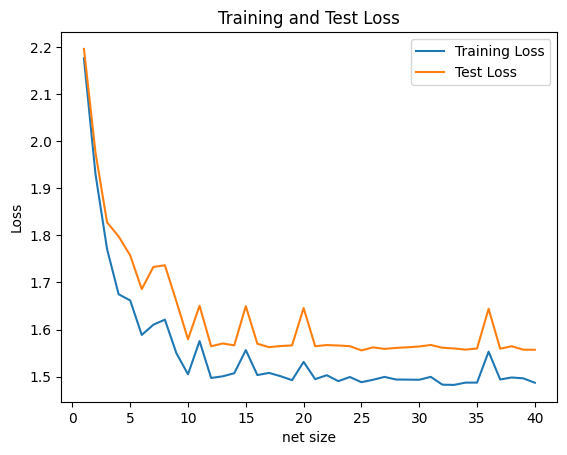

In [7]:
# Plot the training and test loss.
import matplotlib.pyplot as plt
x = np.arange(0, epochs, 1)
plt.title('Training and Test Loss')
plt.xlabel('net size')
plt.ylabel('Loss')
plt.plot(layer_size_list, mean_train_loss_list, label='Training Loss')
plt.plot(layer_size_list, mean_test_loss_list, label='Test Loss')
plt.legend()
plt.show()